# 3. Feature Encoding
## 3.1 Dataset preparation

In [1]:
import sys
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(sys.version)

3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
# import block
import tensorflow as tf
from keras.datasets import cifar10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
import seaborn as sns

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
x_train[0][0][0:3]

array([[0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746]], dtype=float32)

In [6]:
# Checking the results
print("data type", type(x_train), type(x_test),type(y_train),type(y_test))
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

data type <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

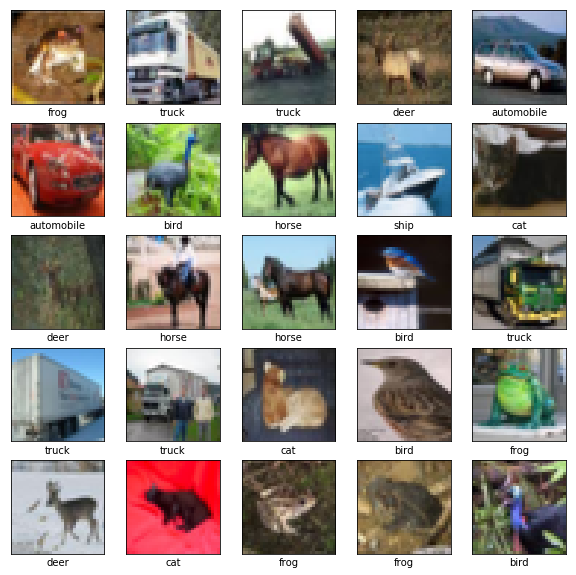

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Building Autoencoders

In [38]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

In [39]:
# Parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 1000
display_step = 1
examples_to_show = 10

In [40]:
def autoencoder():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #latent space
    middle = Dense(10)(x)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [41]:
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [42]:
encoder, model = autoencoder()

In [43]:
model.compile(SGD(1e-3, 0.9), loss=loss_function)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128 

In [44]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model.fit(x_train, x_train, 
                       batch_size= batch_size,
                       epochs=training_epochs,
                       verbose=1,
#                        validation_data=(x_valid, x_valid),
                       shuffle=True, callbacks=callbacks)
#                        class_weight=class_weights)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 22.0547

W0626 13:56:14.412272 4572642752 callbacks.py:1497] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss
W0626 13:56:14.423010 4572642752 callbacks.py:2249] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,lr


50/50 [==============================] - 210s 4s/step - loss: 22.0547 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 10.5018

W0626 13:59:54.838572 4572642752 callbacks.py:1497] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss
W0626 13:59:54.844997 4572642752 callbacks.py:2249] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,lr


50/50 [==============================] - 215s 4s/step - loss: 10.5018 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 9.2411

W0626 14:03:10.644788 4572642752 callbacks.py:1497] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss
W0626 14:03:10.646197 4572642752 callbacks.py:2249] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,lr


50/50 [==============================] - 191s 4s/step - loss: 9.2411 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 8.6797

W0626 14:06:15.091704 4572642752 callbacks.py:1497] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss
W0626 14:06:15.093018 4572642752 callbacks.py:2249] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,lr


50/50 [==============================] - 181s 4s/step - loss: 8.6797 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - ETA: 0s - loss: 8.1743

W0626 14:09:16.664576 4572642752 callbacks.py:1497] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss
W0626 14:09:16.665913 4572642752 callbacks.py:2249] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,lr


50/50 [==============================] - 178s 4s/step - loss: 8.1743 - lr: 0.0010


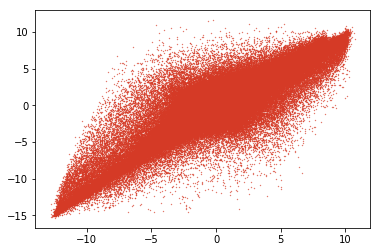

In [45]:
# transform each input image into the latent space
z = encoder.predict(x_test)

# plot the latent space
plt.scatter(z[:,0],z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

In [97]:
filepath = "D:/ProjectsFolder/mmbr"
tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')

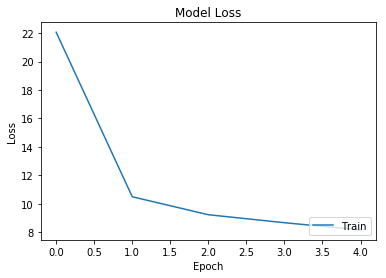

In [46]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

KeyError: 'val_acc'

In [50]:

print("Average test loss: ", np.average(training_history.history['loss']))

ValueError: ('Could not interpret optimizer identifier:', <keras.optimizers.SGD object at 0x14b7bffd0>)

In [51]:
print("Average test loss: ", np.average(history.history['loss']))

Average test loss:  11.730349159240722


# Analyzing the Trained Autoencoder

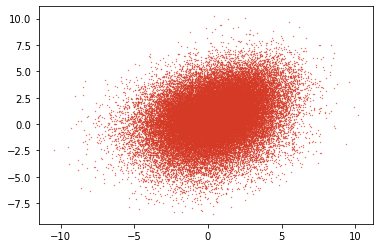

In [30]:
import matplotlib.pyplot as plt

# transform each input image into the latent space
z = autoencoder.encoder.predict(x_train)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

Sampling from the Latent Space

In [54]:
# sample from the region 10, 50 in the latent space
y = np.array([[12,43,78,23,56,89,54,78,2,9]])
prediction = autoencoder.decoder.predict(y)
plt.imshow(prediction.squeeze(), cmap='gray')

AttributeError: 'function' object has no attribute 'decoder'

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()